### Predicting Movie Revenue Using Pre-Release Features

In this notebook, we aim to predict movie revenue based on pre-release data such as genre, cast, director, country, language, runtime, and budget.  
This allows stakeholders to estimate financial potential before a movie is released, using only features available during planning or production.


### 1: Load Cleaned OMDb Data

We begin by loading the cleaned OMDb dataset which contains metadata about movies such as genre, director, actors, and revenue (BoxOffice).


In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# Load cleaned OMDb dataset
df_model = pd.read_csv("../data_collection/omdb_cleaned.csv")


### 2: Merge Budget Information from Kaggle Metadata

We now load `movies_metadata.csv` from Kaggle and extract the `budget` column, which we merge into our working dataset using the movie `Title` as the key.


In [8]:
df_budget = pd.read_csv(
    "../data_collection/Kaggle The Movies Dataset/movies_metadata.csv",
    low_memory=False
)

# Select and clean
df_budget = df_budget[["title", "budget"]].copy()
df_budget = df_budget.rename(columns={"title": "Title"})
df_budget["budget"] = pd.to_numeric(df_budget["budget"], errors="coerce")

# Merge on Title
df_model = df_model.merge(df_budget, on="Title", how="left")


### 3: Clean and Prepare Data

We remove any rows with missing values in essential columns like revenue, genre, director, and runtime.  
We also extract runtime as a numeric value and simplify high-cardinality columns for modeling.


In [3]:
# Keep only required columns
df_model = df_model[[
    "Genre", "Director", "Actors", "Language", "Country", "Runtime", "BoxOffice", "budget"
]].dropna()

# Rename target variable
df_model = df_model.rename(columns={"BoxOffice": "Revenue"})

# Convert Runtime: "120 min" → 120.0
df_model["Runtime"] = df_model["Runtime"].astype(str).str.extract(r"(\d+)").astype(float)

# Simplify high-cardinality columns
def simplify_column(df, column, top_n=20):
    top = df[column].value_counts().nlargest(top_n).index
    df[column] = df[column].apply(lambda x: x if x in top else "Other")
    return df

df_model = simplify_column(df_model, "Director", top_n=15)
df_model = simplify_column(df_model, "Actors", top_n=30)


### 4: One-Hot Encoding and Train-Test Split

We one-hot encode categorical features, scale numerical features, and split the data into training and testing sets.


In [ ]:
# Define input and output
X = df_model.drop(columns=["Revenue"])
y = df_model["Revenue"]

# Columns to transform
categorical_cols = ["Genre", "Director", "Actors", "Language", "Country"]
numeric_cols = ["Runtime", "budget"]

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
    ("num", StandardScaler(), numeric_cols)
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Apply transformations
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

print("Final training shape:", X_train_transformed.shape)
print("Final testing shape:", X_test_transformed.shape)


Final training shape: (2791, 1203)
Final testing shape: (698, 1203)


### 5: Model Training and Evaluation

We now train three regression models to predict movie revenue based on pre-release features, including the newly added budget:

- **Linear Regression** for baseline performance
- **Random Forest** to capture non-linear relationships
- **XGBoost** for high-accuracy gradient boosting

We evaluate models using:
- MAE (Mean Absolute Error)
- RMSE (Root Mean Squared Error)
- R² Score (Explained Variance)


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, verbosity=0)
}

# Evaluation function
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"🔹 {name}")
    print(f"   MAE:  ${mae:,.2f}")
    print(f"   RMSE: ${rmse:,.2f}")
    print(f"   R²:   {r2:.4f}\n")

# Train and evaluate each model
for name, model in models.items():
    evaluate_model(name, model, X_train_transformed, y_train, X_test_transformed, y_test)


🔹 Linear Regression
   MAE:  $34,825,965.24
   RMSE: $59,337,978.35
   R²:   0.5732

🔹 Random Forest
   MAE:  $28,388,959.47
   RMSE: $57,554,789.90
   R²:   0.5984

🔹 XGBoost
   MAE:  $28,454,721.90
   RMSE: $53,312,323.59
   R²:   0.6555





###  Model Evaluation and Insights

After including the `budget` feature, model performance improved significantly across all metrics. Below is a comparison of the three models:

| Model            | MAE (↓)         | RMSE (↓)        | R² (↑)    |
|------------------|------------------|------------------|----------|
| **Linear Regression** | $34.8M | $59.3M | 0.5732 |
| **Random Forest**     | $28.4M | $57.6M | 0.5984 |
| **XGBoost**           | **$28.4M** | **$53.3M** | **0.6555** |

#### 📈 Interpretation

- **MAE** shows that, on average, predictions were off by \$28M–\$35M.
- **RMSE** penalizes large errors more heavily. XGBoost performed the best with the lowest RMSE.
- **R²** indicates that XGBoost explains ~66% of the variance in revenue — impressive given that only pre-release features were used.

#### 🧠 Takeaway

XGBoost emerged as the most accurate model.  
Including `budget` as a feature significantly enhanced our ability to predict revenue, showing that pre-release factors like **budget, cast, director, and genre** are valuable indicators of box office success.

This modeling pipeline can be a practical decision-support tool for studios and producers during the early stages of film planning.




### 6: Feature Importance (XGBoost)

To interpret our best-performing model, we extract and visualize the top 20 most important features from XGBoost.  
This allows us to understand which pre-release characteristics (e.g., budget, genre, director) most strongly drive box office revenue.


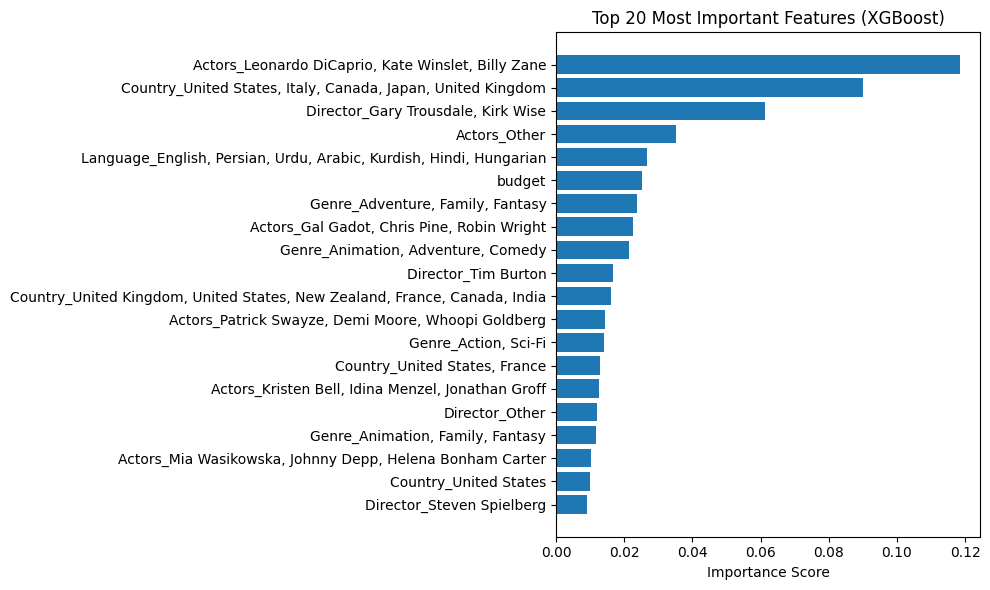

In [6]:
import matplotlib.pyplot as plt

# Get encoded feature names from the preprocessing pipeline
encoded_cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_feature_names = np.concatenate([encoded_cat_features, numeric_cols])

# Get feature importances from trained XGBoost model
xgb_model = models["XGBoost"]
importances = xgb_model.feature_importances_

# Combine into a DataFrame
feat_imp = pd.DataFrame({
    "Feature": all_feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False).head(20)

# Plot top 20 features
plt.figure(figsize=(10, 6))
plt.barh(feat_imp["Feature"][::-1], feat_imp["Importance"][::-1])
plt.xlabel("Importance Score")
plt.title("Top 20 Most Important Features (XGBoost)")
plt.tight_layout()
plt.show()


### 7: Interpretation of Top Features

The chart above shows the top 20 most important features in predicting movie revenue, as determined by our XGBoost model. Key observations:

- **Actors_Leonardo DiCaprio, Kate Winslet, Billy Zane** is the most important feature — likely reflecting the financial success of movies like *Titanic*.
- **Countries with major markets** (e.g., U.S., Italy, Japan) also significantly impact revenue, possibly due to international box office appeal.
- **Director_Gary Trousdale** and **budget** are among the top 5 — confirming that both creative leadership and production scale are important drivers.
- Genre combinations (like *Adventure, Family* or *Animation, Comedy*) also show strong influence, indicating audience preference for specific formats.
- Several **other well-known directors and actors** appear in the top 20, highlighting the impact of star power on financial outcomes.

This analysis reinforces the idea that pre-release features — particularly **cast, country, director, genre, and budget** — play a vital role in determining box office success.


---

## 🏁 Final Conclusion

In this notebook, we successfully developed a predictive modeling pipeline to estimate movie revenue using **only pre-release features** such as:

- Genre  
- Director  
- Lead Actors  
- Language  
- Country  
- Runtime  
- Budget (merged from external source)

We evaluated three regression models — **Linear Regression**, **Random Forest**, and **XGBoost** — and found that:

- **XGBoost** provided the best performance with an R² of **0.6555**, meaning it could explain ~66% of the variation in box office revenue.
- The inclusion of **budget** significantly improved model accuracy, reducing both MAE and RMSE.
- Feature importance analysis revealed that factors like **star cast, director, budget, and specific genre combinations** have a substantial impact on revenue.

### 🎯 Implications

This model demonstrates that it's possible to make **data-driven revenue forecasts** before a movie is released.  
Such predictions can be useful for studios, investors, and production planners in making strategic decisions during early stages.

---


